In [5]:
!pip install wfdb -q


In [6]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

class ECGAnalyzer:
    PARAMS = {
        'grid': {
            'major': {'color': '#ff9999', 'alpha': 0.3},
            'minor': {'color': '#ff9999', 'alpha': 0.1}
        },
        'line': {'color': '#000000', 'linewidth': 0.6},
        'features': {
            1.0: "Clinical Quality - All waves visible",
            0.5: "Diagnostic - Main components visible",
            0.25: "Monitoring - Basic rhythm visible",
            0.125: "Basic - Limited clinical value",
            0.0625: "Overview - Minimal detail"
        }
    }
    
    def __init__(self, base_path):
        """
        Initialize ECG Analyzer with the base path for ECG records.
        
        Args:
            base_path (str): Base directory containing ECG records
        """
        self.base_path = Path(base_path)
    
    def load_record(self, record_name, channel=0):
        """
        Load an ECG record from the specified path.
        
        Args:
            record_name (str): Name of the record
            channel (int): Channel number to analyze (default: 0)
            
        Returns:
            tuple: (signal data, sampling frequency)
        """
        try:
            record_path = self.base_path / record_name
            record = wfdb.rdrecord(str(record_path))
            return record.p_signal[:, channel], record.fs
        except Exception as e:
            raise ValueError(f"Error loading record {record_name}: {str(e)}")
    
    def analyze_ecg(self, record_name, duration=10, channel=0):
        """
        Analyze ECG data at different sampling rates and plot the results.
        
        Args:
            record_name (str): Name of the record to analyze
            duration (int): Duration in seconds to analyze (default: 10)
            channel (int): Channel number to analyze (default: 0)
        """
        try:
            # Load the signal
            signal, fs = self.load_record(record_name, channel)
            
            # Define periods to analyze
            periods = {
                'Start': 0,
                'Mid': len(signal)//2,
                'End': len(signal)-duration*fs
            }
            
            # Create figure
            fig, axs = plt.subplots(15, 1, figsize=(15, 45), facecolor='#F0F0F0')
            fig.suptitle(f'ECG Analysis: Record {record_name}\nSampling Rate Effects', 
                        fontsize=14, y=0.92)
            
            # Plot for each period and sampling rate
            for i, (name, start) in enumerate(periods.items()):
                segment = signal[start:start + duration*fs]
                time = np.arange(len(segment)) / fs
                
                for j, rate in enumerate([1.0, 0.5, 0.25, 0.125, 0.0625]):
                    ax = axs[i*5 + j]
                    factor = int(1/rate)
                    
                    # Style the plot
                    ax.set_facecolor('white')
                    ax.grid(True, which='major', **self.PARAMS['grid']['major'])
                    ax.grid(True, which='minor', **self.PARAMS['grid']['minor'])
                    ax.minorticks_on()
                    
                    # Plot the data
                    ax.plot(time[::factor], segment[::factor], **self.PARAMS['line'])
                    
                    # Add labels and annotations
                    ax.set_title(f"{name} Period - {int(fs*rate)} Hz", loc='left')
                    ax.text(1.02, 0.5, self.PARAMS['features'][rate], 
                           transform=ax.transAxes,
                           bbox=dict(facecolor='#f5f5f5', alpha=0.95))
                    
                    if i*5+j == 14:
                        ax.set_xlabel('Time (s)')
                    ax.set_ylabel('mV')
            
            plt.tight_layout()
            plt.subplots_adjust(right=0.85)
            plt.show()
            
        except Exception as e:
            print(f"Error analyzing ECG: {str(e)}")
    
    def get_available_records(self):
        """
        Get a list of available record names in the base directory.
        
        Returns:
            list: Available record names
        """
        try:
            return [p.stem for p in self.base_path.glob('*.hea')]
        except Exception as e:
            print(f"Error listing records: {str(e)}")
            return []

# Example usage:
"""
# Initialize analyzer with your data path
analyzer = ECGAnalyzer('/path/to/ecg/data')

# List available records
print("Available records:", analyzer.get_available_records())

# Analyze a specific record
analyzer.analyze_ecg('418')  # or any other record name
"""

'\n# Initialize analyzer with your data path\nanalyzer = ECGAnalyzer(\'/path/to/ecg/data\')\n\n# List available records\nprint("Available records:", analyzer.get_available_records())\n\n# Analyze a specific record\nanalyzer.analyze_ecg(\'418\')  # or any other record name\n'

Available records: ['418']


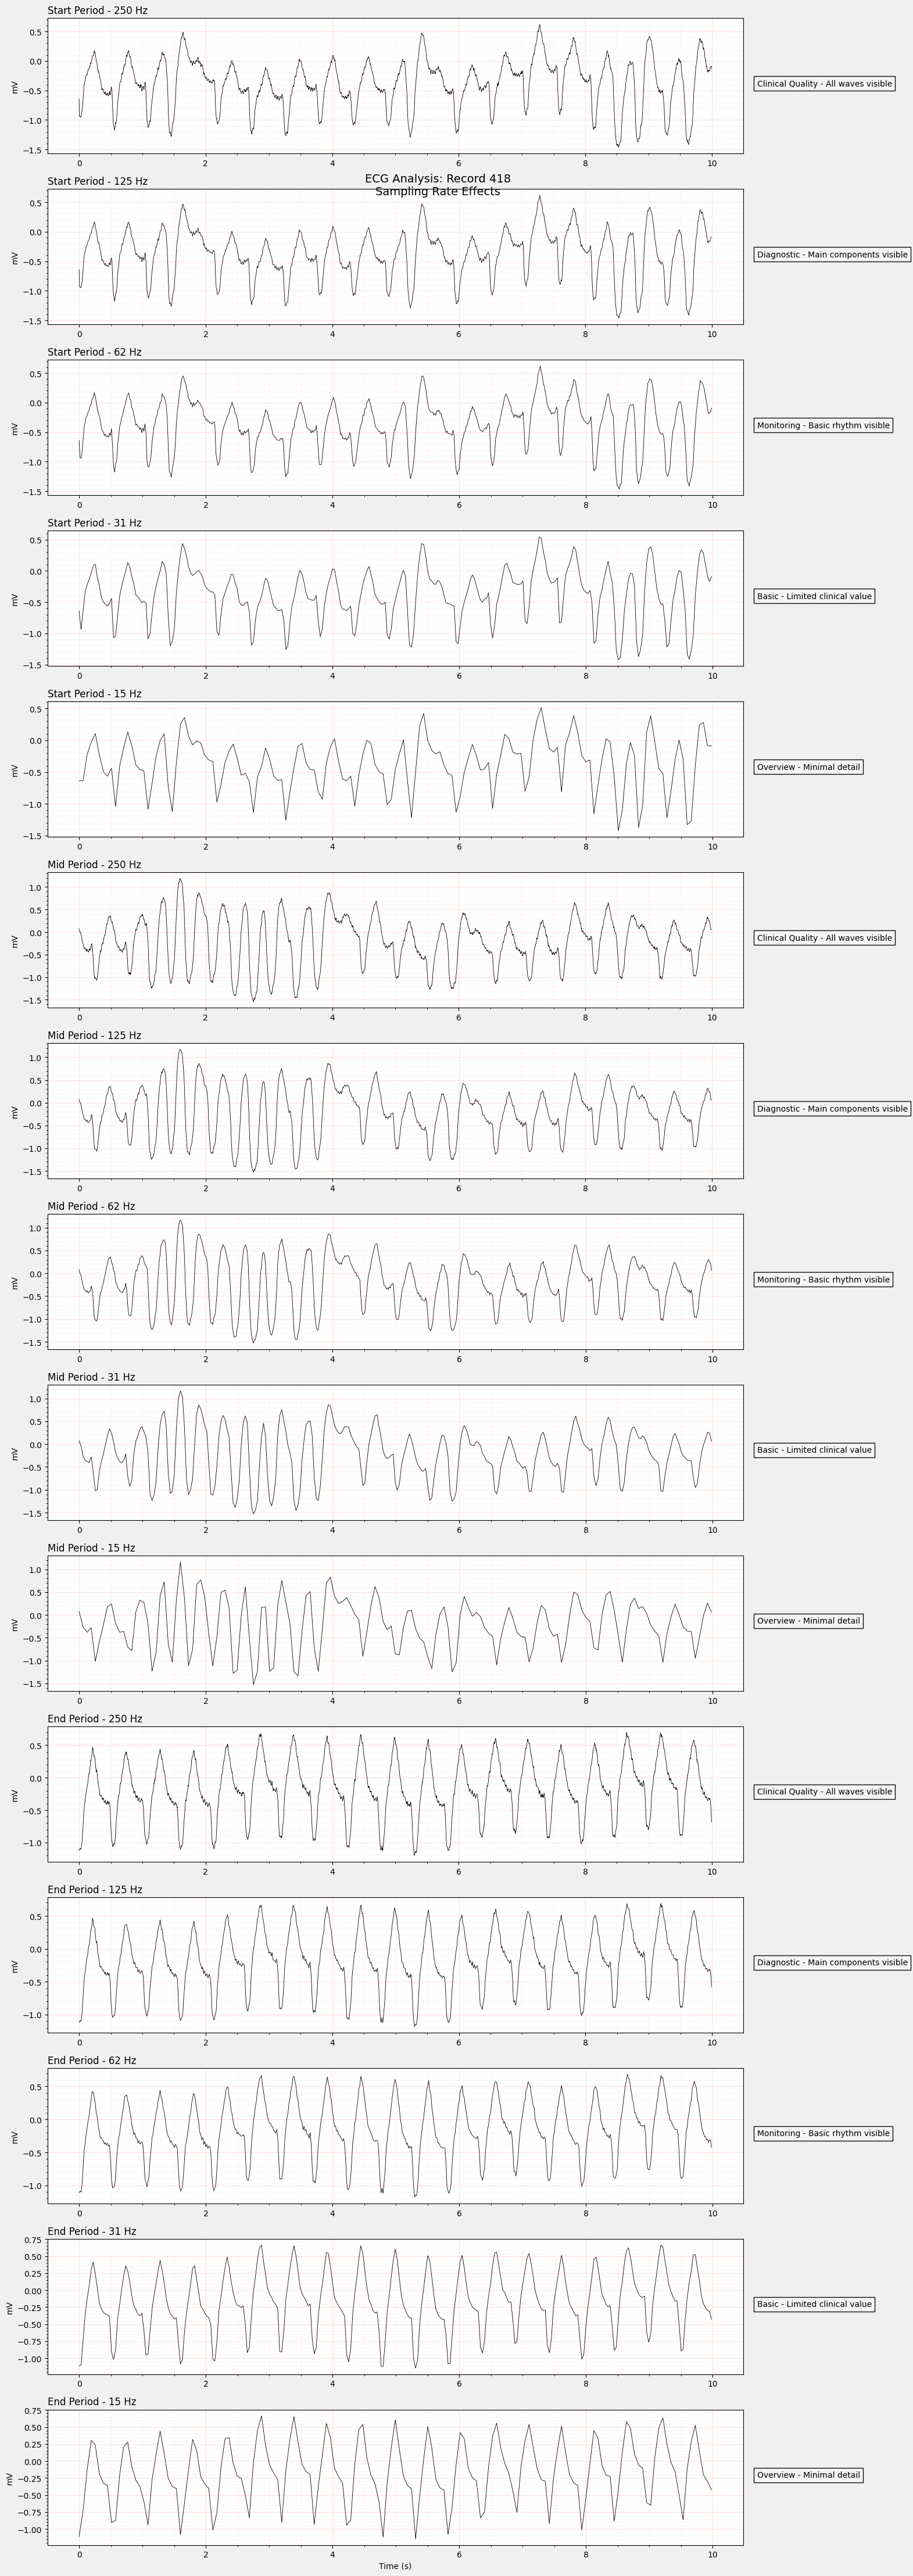

In [7]:
# Initialize analyzer with your data path
analyzer = ECGAnalyzer('/kaggle/input/newdatset')

# List available records
print("Available records:", analyzer.get_available_records())

# Analyze a specific record
analyzer.analyze_ecg('418')  # or any other record name

In [8]:
import numpy as np
import wfdb
from scipy import signal
from datetime import datetime, timedelta
import itertools

CONFIG = {
    'qrs': {
        'filter': [5, 15],          # Bandpass filter range in Hz
        'window': 0.08,             # Integration window in seconds
        'threshold': 0.3,           # Peak detection threshold
        'min_dist': 0.2             # Minimum distance between peaks in seconds
    },
    'st': {
        'thresholds': {
            'depression': 0.1,
            'elevation': 0.3
        },
        'duration': 60,             # Duration for ST analysis in seconds
        'interval': 60              # Interval between analyses in seconds
    },
    'hr': {
        'brady': 50,               # Bradycardia threshold in bpm
        'tachy': 120,              # Tachycardia threshold in bpm
        'rr_range': [400, 2000],   # Valid RR interval range in ms
        'limits': [20, 200]        # Valid heart rate range in bpm
    },
    'prematuridade_sv': 0.30,      # Supraventricular prematurity threshold
    'pausa_min': 2.0               # Minimum pause duration in seconds
}

def detect_qrs(ecg, fs):
    """
    Detect QRS complexes in ECG signal using bandpass filtering and peak detection.
    
    Args:
        ecg (np.array): ECG signal
        fs (float): Sampling frequency in Hz
        
    Returns:
        np.array: Indices of detected QRS complexes
    """
    # Bandpass filter
    b, a = signal.butter(3, [c/(fs/2) for c in CONFIG['qrs']['filter']], 'band')
    filtered = signal.filtfilt(b, a, ecg)
    
    # Derivative and square
    squared = np.diff(filtered)**2
    
    # Moving integration
    win_size = int(CONFIG['qrs']['window']*fs)
    integrated = np.convolve(squared, np.ones(win_size)/win_size, 'same')
    
    # Find peaks
    peaks = signal.find_peaks(
        integrated,
        distance=int(CONFIG['qrs']['min_dist']*fs),
        height=CONFIG['qrs']['threshold']*np.mean(integrated)
    )[0]
    
    # Refine peak locations
    return np.array([
        p + np.argmax(np.abs(ecg[p:p+int(0.05*fs)]))
        for p in peaks if p < len(ecg)-int(0.05*fs)
    ])

def analyze_holter(signal, fs):
    """
    Perform comprehensive Holter analysis on ECG signal.
    
    Args:
        signal (np.array): ECG signal
        fs (float): Sampling frequency in Hz
        
    Returns:
        dict: Analysis results including heart rate and arrhythmia metrics
    """
    # Normalize signal
    signal = (signal - np.median(signal)) / (np.percentile(signal,75) - np.percentile(signal,25))
    
    # Detect QRS complexes
    peaks = detect_qrs(signal, fs)
    
    # Calculate RR intervals
    rr = np.diff(peaks) / fs * 1000
    valid_rr = rr[
        (rr >= CONFIG['hr']['rr_range'][0]) & 
        (rr <= CONFIG['hr']['rr_range'][1])
    ]
    
    # Calculate heart rates
    hr = 60000/valid_rr
    hr = hr[
        (hr >= CONFIG['hr']['limits'][0]) & 
        (hr <= CONFIG['hr']['limits'][1])
    ]
    
    # Calculate RR statistics
    mean_rr = np.median(valid_rr)
    rr_mad = np.median(np.abs(valid_rr - mean_rr))
    
    # Detect arrhythmias
    vent_idx = np.where(
        (valid_rr < 0.7*mean_rr) & 
        (valid_rr > 200) & 
        (np.abs(valid_rr - mean_rr) > 3*rr_mad)
    )[0]
    
    sv_idx = np.where(
        (valid_rr < (1-CONFIG['prematuridade_sv'])*mean_rr) & 
        (valid_rr > 0.7*mean_rr)
    )[0]
    
    # Analyze runs
    vent_runs = [len(list(g)) for _, g in itertools.groupby(np.diff(vent_idx) == 1) if g]
    sv_runs = [len(list(g)) for _, g in itertools.groupby(np.diff(sv_idx) == 1) if g]
    
    # Analyze tachycardia
    tachy_mask = hr >= CONFIG['hr']['tachy']
    tachy_idx = np.where(tachy_mask)[0]
    tachy_runs = [len(list(g)) for _, g in itertools.groupby(np.diff(tachy_idx) == 1) if g]
    
    total_time = len(signal)/(fs*3600)
    
    return {
        'summary': {
            'total_qrs': len(peaks),
            'duration_hours': total_time,
            'artifacts': (len(rr) - len(valid_rr))/len(rr) * 100 if len(rr) > 0 else 0
        },
        'hr': {
            'min': float(np.percentile(hr, 1)) if len(hr) > 0 else 0,
            'mean': float(np.median(hr)) if len(hr) > 0 else 0,
            'max': float(np.percentile(hr, 99)) if len(hr) > 0 else 0,
            'brady_time': float(np.sum(hr < CONFIG['hr']['brady'])/len(hr) * total_time) if len(hr) > 0 else 0,
            'tachy_episodes': len([r for r in tachy_runs if r >= 4])
        },
        'arrhythmias': {
            'vent_total': len(vent_idx),
            'vent_isolated': len(vent_idx) - sum(vent_runs) if vent_runs else len(vent_idx),
            'vent_pairs': sum(1 for r in vent_runs if r == 2),
            'vent_runs': sum(1 for r in vent_runs if r > 2),
            'sv_total': len(sv_idx),
            'sv_isolated': len(sv_idx) - sum(sv_runs) if sv_runs else len(sv_idx),
            'sv_pairs': sum(1 for r in sv_runs if r == 2),
            'sv_runs': sum(1 for r in sv_runs if r > 2),
            'pauses': sum(valid_rr > CONFIG['pausa_min']*1000)
        }
    }

def format_report(metrics):
    """
    Format analysis results into a readable report.
    
    Args:
        metrics (dict): Analysis results from analyze_holter()
        
    Returns:
        str: Formatted report
    """
    d = timedelta(hours=metrics['summary']['duration_hours'])
    b = timedelta(hours=metrics['hr']['brady_time'])
    
    return "\n".join([
        f"RESUMO HOLTER - {d.total_seconds()/3600:.1f}h",
        "="*50,
        f"\nDados Gerais:",
        f"QRS's: {metrics['summary']['total_qrs']:,}",
        f"Duração: {d}",
        f"Artefatos: {metrics['summary']['artifacts']:.1f}%",
        f"\nEctópicos:",
        f"Ventriculares: {metrics['arrhythmias']['vent_total']}",
        f"Supraventriculares: {metrics['arrhythmias']['sv_total']}",
        f"\nArritmias Ventriculares:",
        f"Isoladas: {metrics['arrhythmias']['vent_isolated']}",
        f"Pares: {metrics['arrhythmias']['vent_pairs']}",
        f"Taquicardia: {metrics['arrhythmias']['vent_runs']}",
        f"\nArritmias Supraventriculares:",
        f"Isoladas: {metrics['arrhythmias']['sv_isolated']}",
        f"Pares: {metrics['arrhythmias']['sv_pairs']}",
        f"Taquicardia: {metrics['arrhythmias']['sv_runs']}",
        f"\nFrequência Cardíaca:",
        f"Min: {metrics['hr']['min']:.0f} bpm",
        f"Média: {metrics['hr']['mean']:.0f} bpm",
        f"Max: {metrics['hr']['max']:.0f} bpm",
        f"Tempo FC≤{CONFIG['hr']['brady']}bpm: {b}",
        f"\nPausas≥{CONFIG['pausa_min']}s: {metrics['arrhythmias']['pauses']}"
    ])

def analyze_record(record_path):
    """
    Analyze a single ECG record and print the results.
    
    Args:
        record_path (str): Path to the record without extension
        
    Returns:
        dict: Analysis metrics if successful, None if failed
    """
    try:
        record = wfdb.rdrecord(record_path)
        signal = record.p_signal[:,0]  # Use first channel
        metrics = analyze_holter(signal, record.fs)
        print(format_report(metrics))
        return metrics
    except Exception as e:
        print(f"Erro: {e}")
        return None

# Usage with new dataset path
if __name__ == "__main__":
    metrics = analyze_record('/kaggle/input/newdatset/418')

RESUMO HOLTER - 0.6h

Dados Gerais:
QRS's: 5,443
Duração: 0:35:00
Artefatos: 61.9%

Ectópicos:
Ventriculares: 0
Supraventriculares: 0

Arritmias Ventriculares:
Isoladas: 0
Pares: 0
Taquicardia: 0

Arritmias Supraventriculares:
Isoladas: 0
Pares: 0
Taquicardia: 0

Frequência Cardíaca:
Min: 80 bpm
Média: 112 bpm
Max: 147 bpm
Tempo FC≤50bpm: 0:00:00

Pausas≥2.0s: 0
